In [7]:
!pip3 install matplotlib
!pip3 install statsmodels

In [8]:
import pandas as pd

# Загрузка данных
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

# Преобразование даты
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# Сортировка по дате
train = train.sort_values('dt').reset_index(drop=True)
test = test.sort_values('dt').reset_index(drop=True)

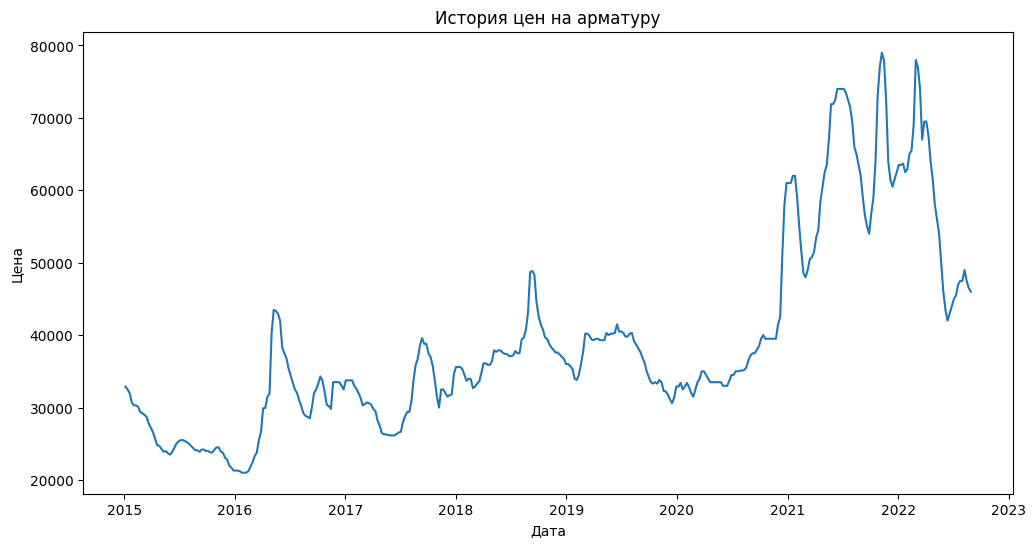

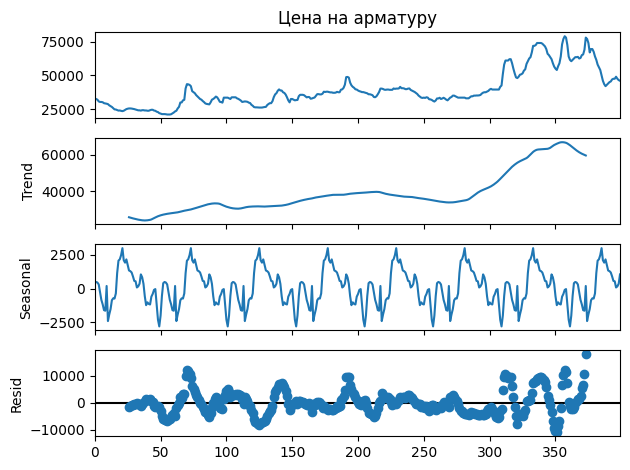

In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# График цен
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], train['Цена на арматуру'])
plt.title('История цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

# Декомпозиция ряда
result = seasonal_decompose(train['Цена на арматуру'], model='additive', period=52)
result.plot()
plt.show()

Генерируем признаки. Создаем лаги для того, чтобы создались цены за прошлые недели(1 - за прошлую, 2- за прошлую и т.д.). Также добавляем скользящее среднее за 8 недель и календарные признаки, которые будут давать понять о сезонности и тренде.

In [ ]:
# Создание лагов
for lag in [1, 2, 3, 4]:
    train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)

# Скользящее среднее за 8 недель
train['Скользящее среднее'] = train['Цена на арматуру'].rolling(window=8).mean()

# Календарные признаки
train['week'] = train['dt'].dt.isocalendar().week
train['month'] = train['dt'].dt.month

In [13]:
train.head(50)

,dt,Цена на арматуру,lag_1,lag_2,lag_3,lag_4,rolling_mean_8,week,month
0,2015-01-05,32900,NaN,NaN,NaN,NaN,NaN,2,1
1,2015-01-12,32500,32900.0,NaN,NaN,NaN,NaN,3,1
2,2015-01-19,32000,32500.0,32900.0,NaN,NaN,NaN,4,1
3,2015-01-26,30700,32000.0,32500.0,32900.0,NaN,NaN,5,1
4,2015-02-02,30300,30700.0,32000.0,32500.0,32900.0,NaN,6,2
5,2015-02-09,30300,30300.0,30700.0,32000.0,32500.0,NaN,7,2
6,2015-02-16,30100,30300.0,30300.0,30700.0,32000.0,NaN,8,2
7,2015-02-23,29400,30100.0,30300.0,30300.0,30700.0,31025.00,9,2
8,2015-03-02,29200,29400.0,30100.0,30300.0,30300.0,30562.50,10,3
9,2015-03-09,29000,29200.0,29400.0,30100.0,30300.0,30125.00,11,3


In [12]:
test.head()

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500
